In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input, Reshape, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
class CGAN(keras.Model):
    def __init__(self, x_dim, y_dim, z_dim): # dim: tuple, z_dim = scalar
        super(CGAN, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(CGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        activation = 'relu'
        z = Input(shape = (self.z_dim, ))
        y = Input(shape = self.y_dim)
        inputs = Concatenate()([z, y])
        
        h = Dense(256)(inputs)
        h = Activation(activation)(h)
        h = BatchNormalization(momentum=0.8)(h)
        
        h = Dense(512)(h)
        h = Activation(activation)(h)
        h = BatchNormalization(momentum=0.8)(h)
        
        h = Dense(1024)(h)
        h = Activation(activation)(h)
        
        outputs = Dense(self.x_dim[0], activation='tanh')(h)

        return Model([z, y], outputs, name='generator')

    def build_discriminator(self):
        activation = leakyrelu
        x = Input(shape = self.x_dim)
        y = Input(shape = self.y_dim)
        inputs = Concatenate()([x, y])
        
        h = Dense(512)(inputs)
        h = Activation(activation)(h)
        
        h = Dense(256)(h)
        h = Activation(activation)(h)
        
        outputs = Dense(1)(h)
        return Model([x, y], outputs, name='discriminator')
    
    def train_step(self, data):
        x, y = data
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator([noise, y])
            all_x = tf.concat([x, fake], 0)
            all_y = tf.concat([y, y,], 0)
            preds = self.discriminator([all_x, all_y])

            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator([noise, y])
            preds = self.discriminator([fake, y])
            
            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}



In [4]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            noise = np.random.normal(0, 1, (1, 100))
            r, c = 2, 5
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    cls = to_categorical([n], num_classes=10) # set class whether it can generate target class imgs
                    img = (self.model.generator.predict([noise, cls])*0.5 + 0.5).reshape(28, 28)
                    axs[i,j].imshow(img, cmap='gray')
                    axs[i,j].axis('off')
                    n += 1

            plt.show()
            plt.close()

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = train_X.reshape(-1, 28*28)
train_y = to_categorical(train_y)

In [6]:
gan = CGAN(train_X.shape[1:], train_y.shape[1:], 100)

In [7]:
gan.generator.summary()
print('#'*50)
gan.discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          28416       concatenate[0][0]        

In [8]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

Epoch 1/101
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.4294 - g_loss: 2.2979

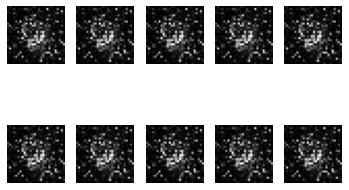

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.4292 - g_loss: 2.3005
Epoch 2/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.2612 - g_loss: 3.6005
Epoch 3/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.1333 - g_loss: 4.3576
Epoch 4/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.0564 - g_loss: 8.0322
Epoch 5/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.3285 - g_loss: 2.4350
Epoch 6/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.4596 - g_loss: 1.6808
Epoch 7/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.5664 - g_loss: 1.2568
Epoch 8/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6017 - g_loss: 1.1149
Epoch 9/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6203 - g_loss: 1.0520
Epoch 10/101
1875/1875 [==============================] - 12s 6ms/step - d_loss

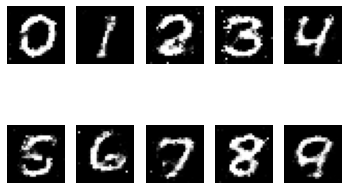

1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6396 - g_loss: 0.9857
Epoch 12/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6473 - g_loss: 0.9636
Epoch 13/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6488 - g_loss: 0.9523
Epoch 14/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6510 - g_loss: 0.9426
Epoch 15/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6525 - g_loss: 0.9394
Epoch 16/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6541 - g_loss: 0.9282
Epoch 17/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6567 - g_loss: 0.9217
Epoch 18/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6564 - g_loss: 0.9171
Epoch 19/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6582 - g_loss: 0.9088
Epoch 20/101
1875/1875 [==============================] - 12s 6ms/st

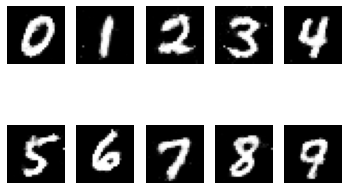

1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6599 - g_loss: 0.8998
Epoch 22/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6577 - g_loss: 0.9036
Epoch 23/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6590 - g_loss: 0.9013
Epoch 24/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6587 - g_loss: 0.9024
Epoch 25/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6625 - g_loss: 0.8885
Epoch 26/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6633 - g_loss: 0.8851
Epoch 27/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6631 - g_loss: 0.8789
Epoch 28/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6639 - g_loss: 0.8789
Epoch 29/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6646 - g_loss: 0.8737
Epoch 30/101
1875/1875 [==============================] - 12s 6ms/st

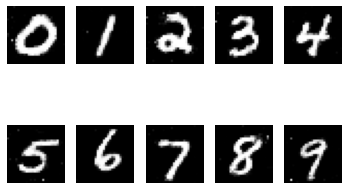

1875/1875 [==============================] - 12s 7ms/step - d_loss: 0.6668 - g_loss: 0.8658
Epoch 32/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6668 - g_loss: 0.8628
Epoch 33/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6661 - g_loss: 0.8625
Epoch 34/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6660 - g_loss: 0.8621
Epoch 35/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6672 - g_loss: 0.8579
Epoch 36/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6653 - g_loss: 0.8632
Epoch 37/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6662 - g_loss: 0.8570
Epoch 38/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6677 - g_loss: 0.8561
Epoch 39/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6664 - g_loss: 0.8569
Epoch 40/101
1875/1875 [==============================] - 11s 6ms/st

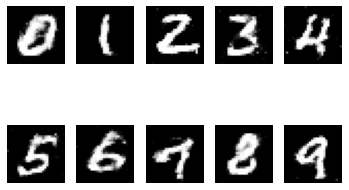

1875/1875 [==============================] - 12s 7ms/step - d_loss: 0.6650 - g_loss: 0.8579
Epoch 42/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6660 - g_loss: 0.8564
Epoch 43/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6649 - g_loss: 0.8583
Epoch 44/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6661 - g_loss: 0.8542
Epoch 45/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6648 - g_loss: 0.8563
Epoch 46/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6649 - g_loss: 0.8574
Epoch 47/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6633 - g_loss: 0.8613
Epoch 48/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6645 - g_loss: 0.8573
Epoch 49/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6627 - g_loss: 0.8611
Epoch 50/101
1875/1875 [==============================] - 12s 6ms/st

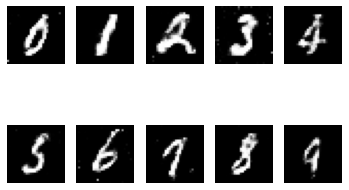

1875/1875 [==============================] - 12s 7ms/step - d_loss: 0.6618 - g_loss: 0.8678
Epoch 52/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6616 - g_loss: 0.8668
Epoch 53/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6612 - g_loss: 0.8685
Epoch 54/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6616 - g_loss: 0.8664
Epoch 55/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6609 - g_loss: 0.8699
Epoch 56/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6603 - g_loss: 0.8699
Epoch 57/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6600 - g_loss: 0.8727
Epoch 58/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6604 - g_loss: 0.8729
Epoch 59/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6602 - g_loss: 0.8727
Epoch 60/101
1875/1875 [==============================] - 12s 6ms/st

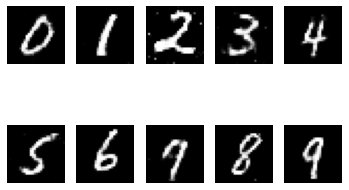

1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6606 - g_loss: 0.8735
Epoch 62/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6589 - g_loss: 0.8775
Epoch 63/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6577 - g_loss: 0.8788
Epoch 64/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6593 - g_loss: 0.8762
Epoch 65/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6586 - g_loss: 0.8781
Epoch 66/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6592 - g_loss: 0.8775
Epoch 67/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6595 - g_loss: 0.8756
Epoch 68/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6583 - g_loss: 0.8797
Epoch 69/101
1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.6583 - g_loss: 0.8793
Epoch 70/101
1875/1875 [==============================] - 8s 4ms/step

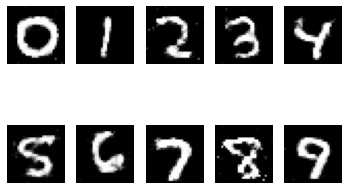

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.6581 - g_loss: 0.8819
Epoch 72/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6573 - g_loss: 0.8826
Epoch 73/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6571 - g_loss: 0.8823
Epoch 74/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6570 - g_loss: 0.8846
Epoch 75/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6554 - g_loss: 0.8882
Epoch 76/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6558 - g_loss: 0.8875
Epoch 77/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6556 - g_loss: 0.8863
Epoch 78/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6558 - g_loss: 0.8876
Epoch 79/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6552 - g_loss: 0.8900
Epoch 80/101
1875/1875 [==============================] - 8s 4ms/step - d_los

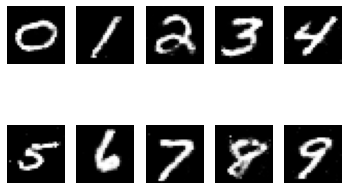

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.6533 - g_loss: 0.8950
Epoch 82/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6530 - g_loss: 0.8975
Epoch 83/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6539 - g_loss: 0.8965
Epoch 84/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6528 - g_loss: 0.8979
Epoch 85/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6534 - g_loss: 0.8983
Epoch 86/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6527 - g_loss: 0.9005
Epoch 87/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6519 - g_loss: 0.9025
Epoch 88/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6514 - g_loss: 0.9045
Epoch 89/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6496 - g_loss: 0.9066
Epoch 90/101
1875/1875 [==============================] - 8s 4ms/step - d_los

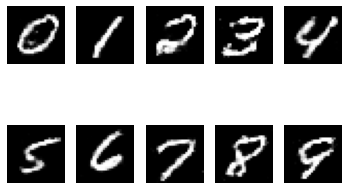

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.6488 - g_loss: 0.9118
Epoch 92/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6486 - g_loss: 0.9146
Epoch 93/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6470 - g_loss: 0.9156
Epoch 94/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6477 - g_loss: 0.9182
Epoch 95/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6484 - g_loss: 0.9146
Epoch 96/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6468 - g_loss: 0.9217
Epoch 97/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6479 - g_loss: 0.9190
Epoch 98/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6463 - g_loss: 0.9239
Epoch 99/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6463 - g_loss: 0.9233
Epoch 100/101
1875/1875 [==============================] - 8s 4ms/step - d_lo

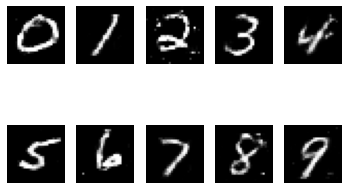

1875/1875 [==============================] - 9s 5ms/step - d_loss: 0.6447 - g_loss: 0.9262


In [9]:
gan.fit(train_X, train_y,
       epochs=101,
       shuffle=True,
       batch_size=32,
       callbacks=[PlotCallback()])